<h1> Setup notebook </h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.misc import imread, imsave, imrotate
import pandas as pd
from scipy.interpolate import UnivariateSpline
import matplotlib.animation as animation
%pylab inline
#plt.rcParams['backend'] = "Qt4Agg"
plt.rcParams['figure.figsize'] = (18.0, 10.0) # set size of figures"
plt.rcParams.update({'font.size': 18})


/Users/attiladobi/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

Populating the interactive namespace from numpy and matplotlib


pylab import has clobbered these variables: ['imsave', 'imread']
`%matplotlib` prevents importing * from pylab and numpy


In [2]:
def interp_row(index,n_rows=16,n_cols=20, ave=20):
    #setup the number of columns in each row. Should be the same as the number of rows used.
    column_len=np.array([20,20,20,20,16,16,15,13,13,10,10,7,7,5,5,5],dtype=int)
    
    sun_rows=np.arange(0,16,2)
    shade_rows=np.arange(3,15,2)
    rows=index[:,0]
    rows_all=np.arange(0,16)
    rows_no_data=rows_all[~np.in1d(np.array(rows_all),np.array([rows]))]
    cols=index[:,1]
    vals=index[:,2]
    sunny_ave=mean(vals[np.in1d(np.array(rows),np.array([sun_rows]))])
    
    #quick interpolation over rows for sun and shade seperately
    rows_data=rows[np.in1d(np.array(rows),np.array([sun_rows]))]
    vals_data=vals[np.in1d(np.array(rows),np.array([sun_rows]))]
    sun_vals_intr=np.interp(sun_rows,rows_data,vals_data)
    sun_rows_no_data=sun_rows[np.in1d(np.array(sun_rows),np.array([rows_no_data]))]
    
    rows_data=rows[np.in1d(np.array(rows),np.array([shade_rows]))]
    vals_data=vals[np.in1d(np.array(rows),np.array([shade_rows]))]
    shade_vals_intr=np.interp(shade_rows,rows_data,vals_data)
    shade_rows_no_data=shade_rows[np.in1d(np.array(shade_rows),np.array([rows_no_data]))]
    
    #use ave= average of the control sensors.... or use the sunny ave calculated above
    Z=ave*np.ones((n_rows,n_cols))
    kk=0
    for jj in arange(min(rows),max(rows_all)+1):
        
        #fill the rows that did not have any data with interpolation value:
        if jj in sun_rows_no_data:
            cut=sun_rows==jj
            Z[jj,:column_len[jj]+1]=sun_vals_intr[cut] # set entire row to that value
            #print(jj,sun_vals_intr[cut],cut)
     
        if jj in shade_rows_no_data:
            cut=shade_rows==jj
            Z[jj,:column_len[jj]+1]=shade_vals_intr[cut] # set entire row to that value
        
        col_nums=cols[index[:,0]==jj]
        for ii, col in enumerate(col_nums):
            if ii==0:
                Z[jj,:column_len[jj]+1]=vals[kk] # set entire row to that value
            if ii>0:
                Z[jj,col:column_len[jj]+1]=vals[kk] # set rest of the row to that value
                Z[jj,col_nums[ii-1]+1:col]=interp(arange(col_nums[ii-1]+1,col),[col_nums[ii-1],col],[Z[jj,col_nums[ii-1]],Z[jj,col]])
            kk=kk+1
    
    return Z

<h1> Make plot with the gird and individual data points </h1>

Size:  90577536
Shape:  (4348, 6944, 3)


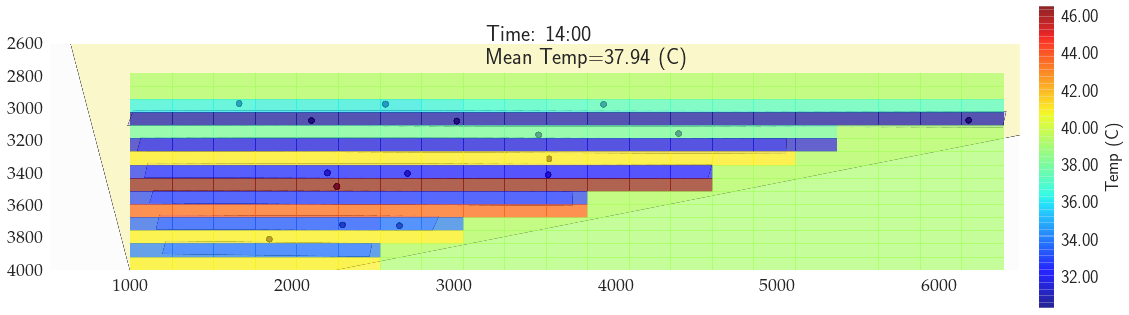

In [346]:
#set the time of day you want to plot.
hour=14

#import the data
vals_hours=loadtxt('data/Ani_temp.txt')
vals_contr=vals_hours[hour][:2] #first two are control. Will be used 
vals=vals_hours[hour][2:] #the rest are measurements

#
image_data = imread('Subsole.jpg').astype(np.float32)
image_data = imrotate(image_data,0.5)

print 'Size: ', image_data.size
print 'Shape: ', image_data.shape

scaled_image_data = image_data / 255.
# Save the modified image if you want to
# imsave('test_out.png', scaled_image_data)

#Make mesh grid
x = np.linspace(1000,6400,22)
y = np.linspace(2780,4000,16) #length of 76 per row (shade or sun)
X, Y = meshgrid(x, y)

#Show image
#fig, ax = plt.subplots()
im=plt.imshow(scaled_image_data,alpha=0.9) #aspect='auto'
plt.ylim([4000,2600])
plt.xlim([500,6500])
#plt.xlabel('xlabel', fontsize=18)
#plt.ylabel('ylabel', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

#show grid
plt.plot(X,Y,'+m')

#first sun row starts at 2, (row number 0 and 1 are equal to the control value)

row_c= [1,20],[0,11],[1,7],[0,6],[1,4],[0,2],[2,13],[2,9],\
[5,10],[4,10],\
[5,6],[5,4],\
[6,4],[9,6],[9,5],[10,3]

#plot indifidual squares
#Z=0*np.ones((14,22))
#for ii in range(len(row_c)):
#    Z[np.array(row_c)[ii][0],np.array(row_c)[ii][1]]=vals[ii]

for ii in range(len(vals)):
    row_c[ii].append(vals[ii])
#row_c
#sort by row number
a=np.array(row_c)
sorted_a=a[np.lexsort(np.fliplr(a).T)]
sorted_a[:,0]=sorted_a[:,0]+2 #here we add two to the values of the rows defined above, since the first two are control.

ave=mean(vals_contr)
Z=interp_row(sorted_a,n_rows=16,n_cols=22,ave=ave) #enter [row, column, val] sorted by row

ax=plt.gca()
plt.pcolor(X,Y,Z,alpha=0.6,cmap='jet') #plot each rectangle
levels=np.linspace(5,48,200) #Z.min(),Z.max()
#plt.contourf(X,Y,Z,levels,alpha=0.7,cmap='nipy_spectral') #good ones: #cmap='jet' #'nipy_spectral'
cb=plt.colorbar(fraction=0.015, pad=0.02,format="%.2f")
cb.set_label('Temp (C)',fontsize=18)
cb.ax.tick_params(labelsize=18)
plt.text(3200,2730,'Time: '+ str(hour)+':00 \n Mean Temp='+'{:.2f}'.format(ave)+' (C)',fontsize=22)

plt.savefig('fig/square_temp_hour'+str(hour)+'.png')

<h1> Plot with contour </h1>

Size:  90577536
Shape:  (4348, 6944, 3)


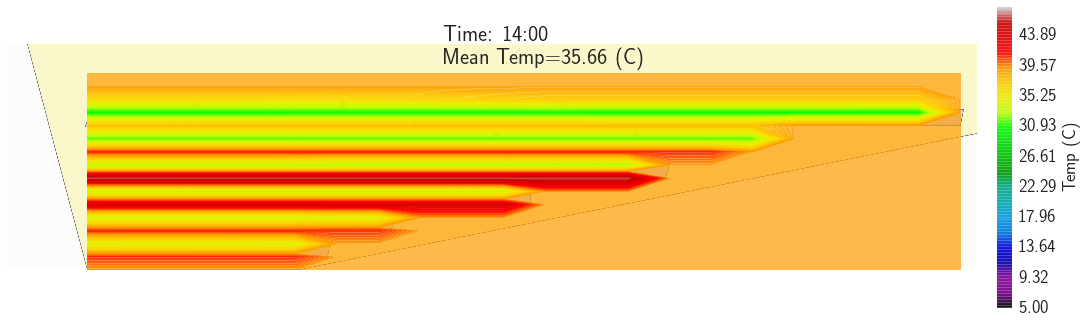

In [388]:
#set the time of day you want to plot.
hour=14

#import the data
vals_hours=loadtxt('data/Ani_temp.txt')
vals_contr=vals_hours[hour][:2] #first two are control. Will be used 
vals=vals_hours[hour][2:] #the rest are measurements
#ave_all=mean(vals_hours[hour]) #average of all the sensors

#
image_data = imread('Subsole.jpg').astype(np.float32)
image_data = imrotate(image_data,0.7)

print 'Size: ', image_data.size
print 'Shape: ', image_data.shape

scaled_image_data = image_data / 255.
# Save the modified image if you want to
# imsave('test_out.png', scaled_image_data)

#Make mesh grid
x = np.linspace(1000,6400,22)
y = np.linspace(2780,4000,16) #length of 76 per row (shade or sun)
X, Y = meshgrid(x, y)

#Show image
#fig, ax = plt.subplots()
im=plt.imshow(scaled_image_data,alpha=0.9) #aspect='auto'
plt.ylim([4000,2600])
plt.xlim([500,6500])
#plt.xlabel('xlabel', fontsize=18)
#plt.ylabel('ylabel', fontsize=18)
plt.xticks([],fontsize=18)
plt.yticks([],fontsize=18)

#show grid
plt.plot(X,Y,'+m')

#first sun row starts at 2, (row number 0 and 1 are equal to the control value)

row_c= [1,20],[0,11],[1,7],[0,6],[1,4],[0,2],[2,13],[2,9],\
[5,10],[4,10],\
[5,6],[5,4],\
[6,4],[9,6],[9,5],[10,3]

#append row,column coordinates with values
for ii in range(len(vals)):
    row_c[ii].append(vals[ii])

#sort by row number
a=np.array(row_c)
sorted_a=a[np.lexsort(np.fliplr(a).T)]
sorted_a[:,0]=sorted_a[:,0]+2 #here we add two to the values of the rows defined above, since the first two are control.

ave=mean(vals_contr)
Z=interp_row(sorted_a,n_rows=16,n_cols=22,ave=ave) #enter [row, column, val] sorted by row

ax=plt.gca()

#plot squares:
#plt.pcolor(X,Y,Z,alpha=0.6,cmap='jet') #plot each rectangle

#contour plot:
levels=np.linspace(5,48,200) #Z.min(),Z.max()
plt.contourf(X,Y,Z,levels,alpha=0.7,cmap='nipy_spectral',nchunk   =0) #good ones: #cmap='jet' #'nipy_spectral'

#pick interpolation of squares ... still testing this
#extent = [X.min(), X.max(), Y.max(), Y.min()] # extent of the plot
#plt.imshow(Z, extent=extent, cmap='nipy_spectral', vmin=0, vmax=50, aspect='auto', interpolation='none',alpha=0.7)

cb=plt.colorbar(fraction=0.015, pad=0.02,format="%.2f")
cb.set_label('Temp (C)',fontsize=18)
cb.ax.tick_params(labelsize=18)
plt.text(3200,2730,'Time: '+ str(hour)+':00 \n Mean Temp='+'{:.2f}'.format(mean(vals))+' (C)',fontsize=22)

plt.savefig('fig/contour_temp_hour'+str(hour)+'.png')

<h1> Make a Movie (this works by saving .png files) </h1>

Size:  90577536
Shape:  (4348, 6944, 3)


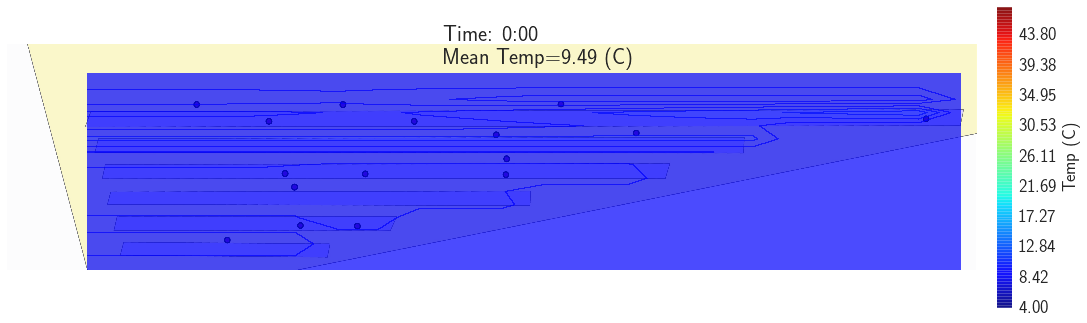

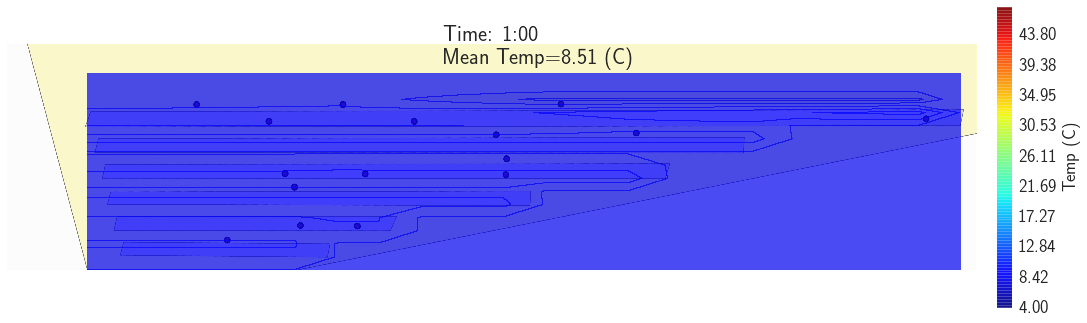

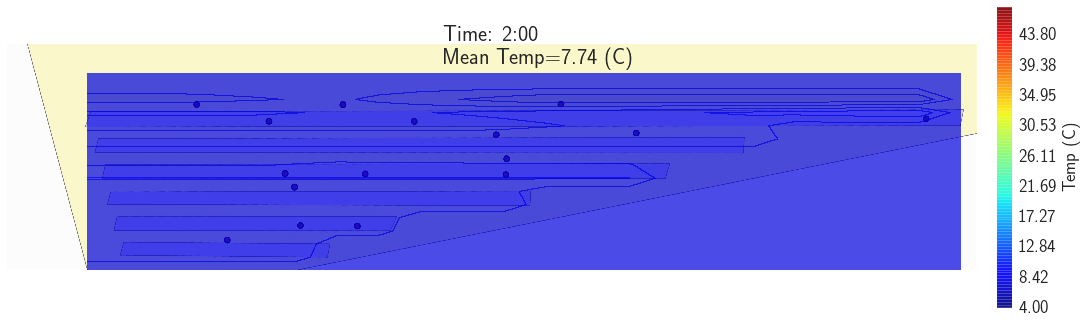

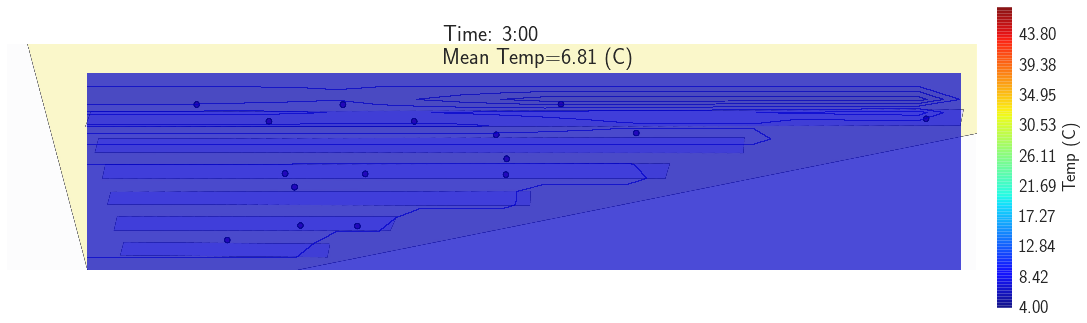

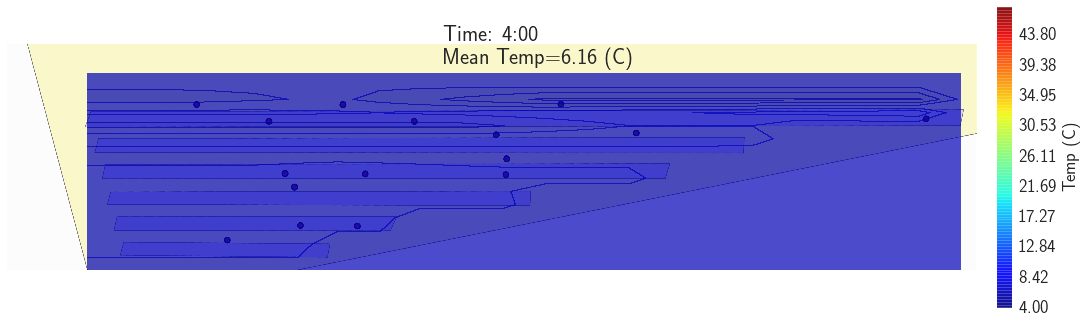

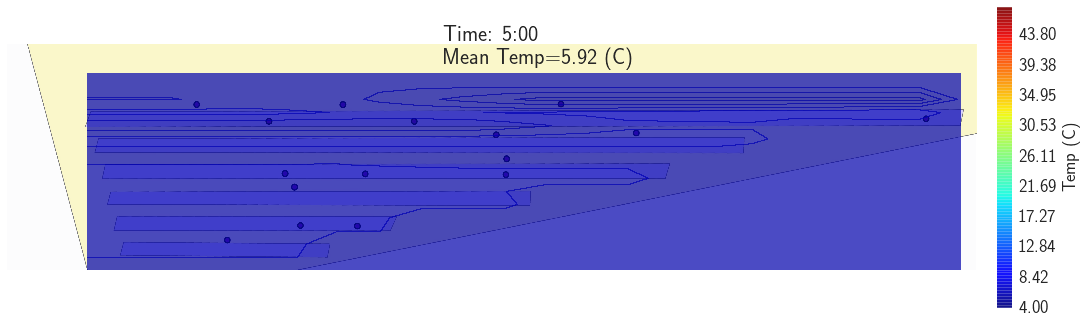

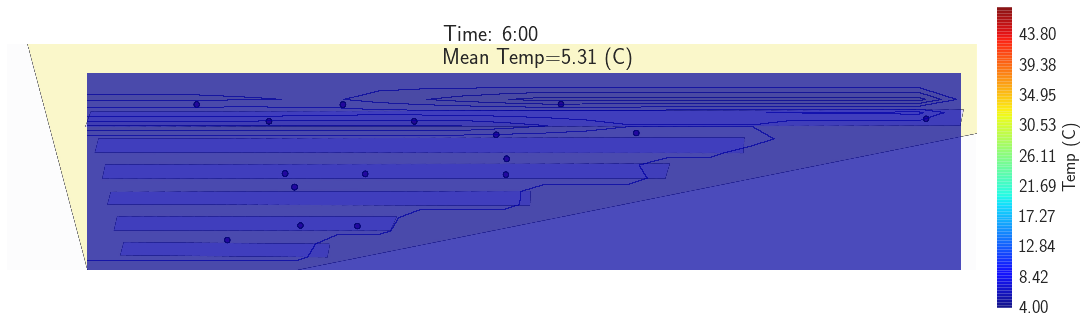

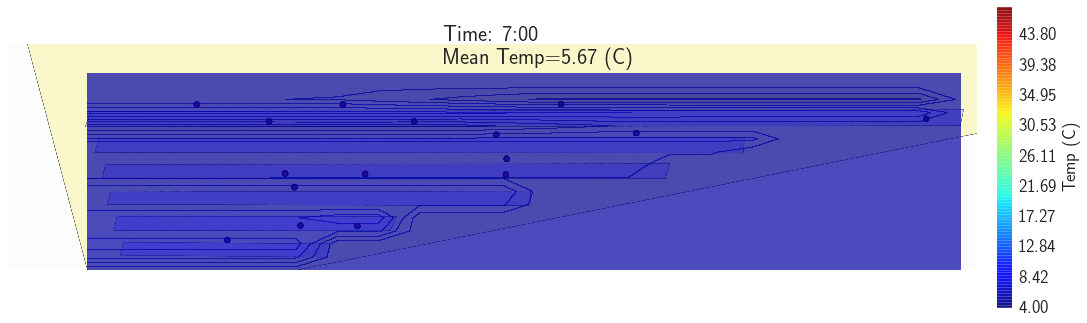

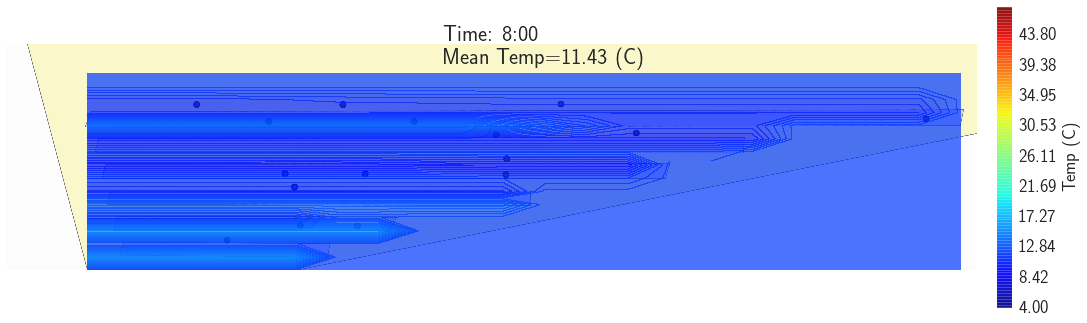

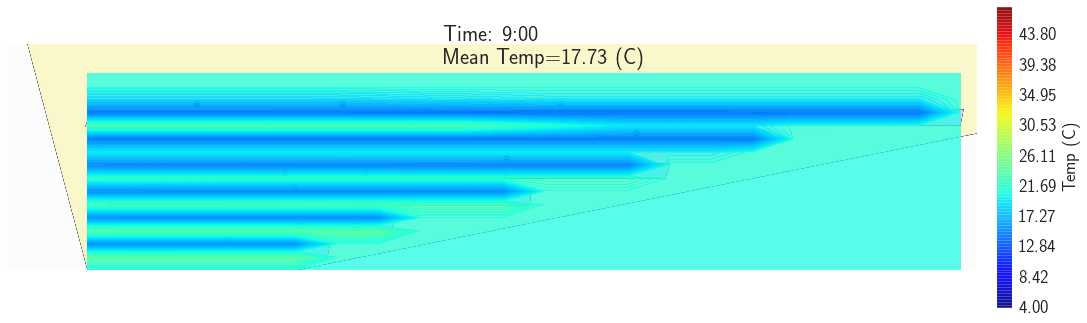

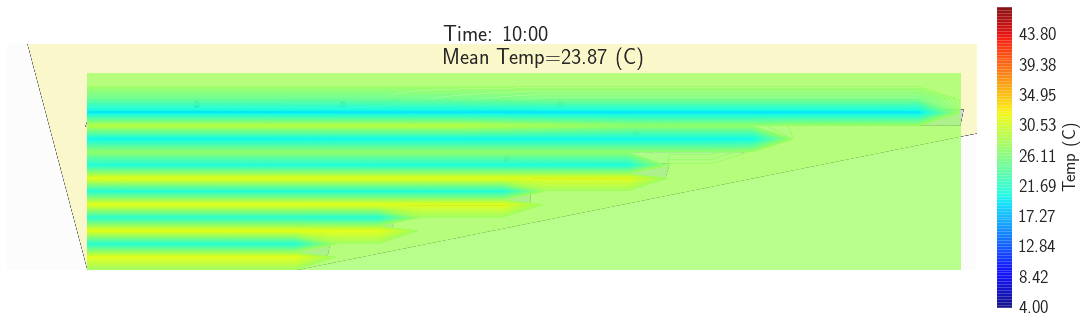

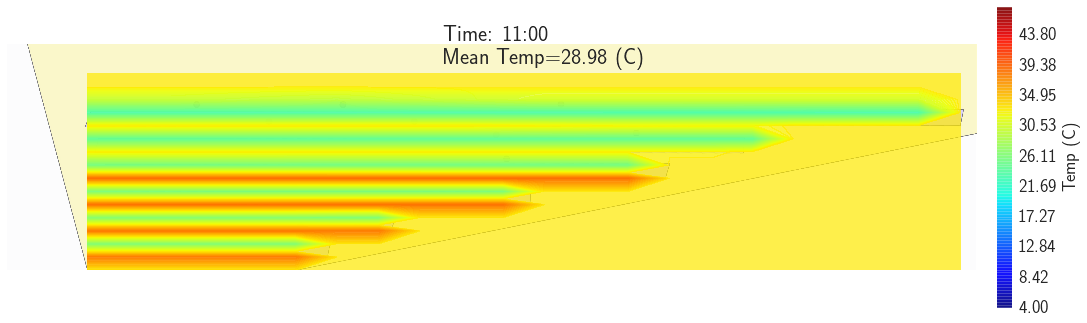

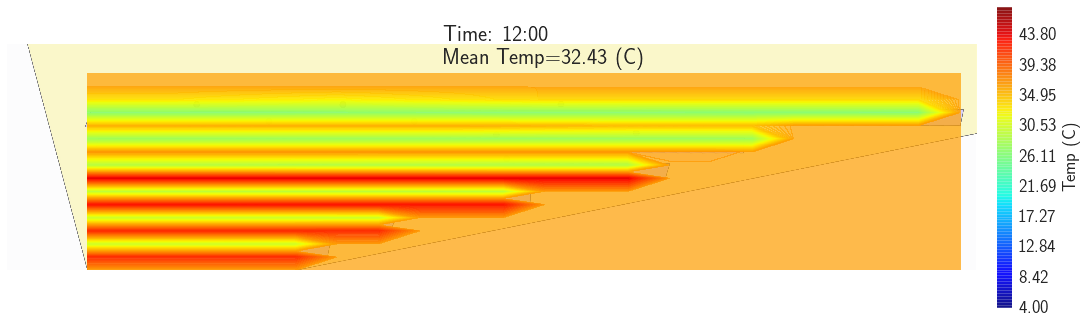

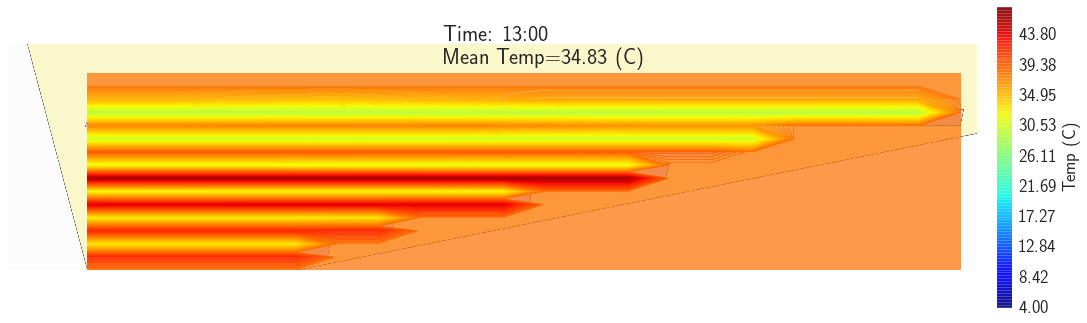

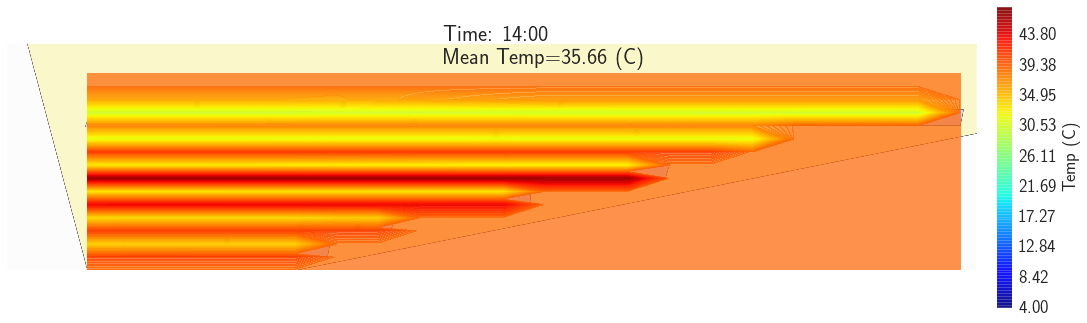

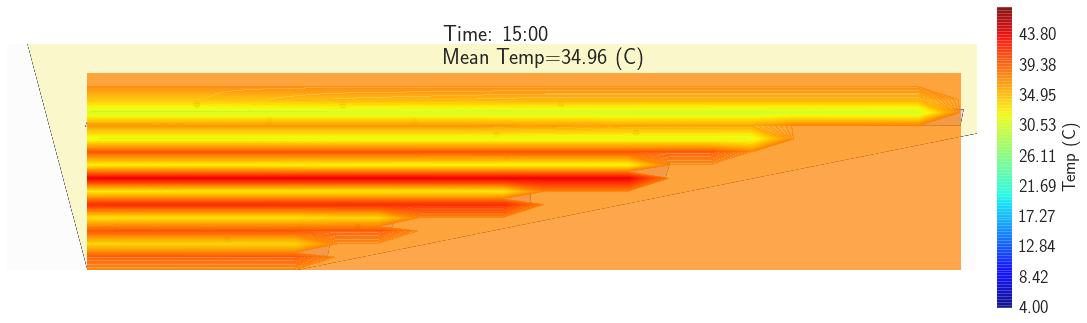

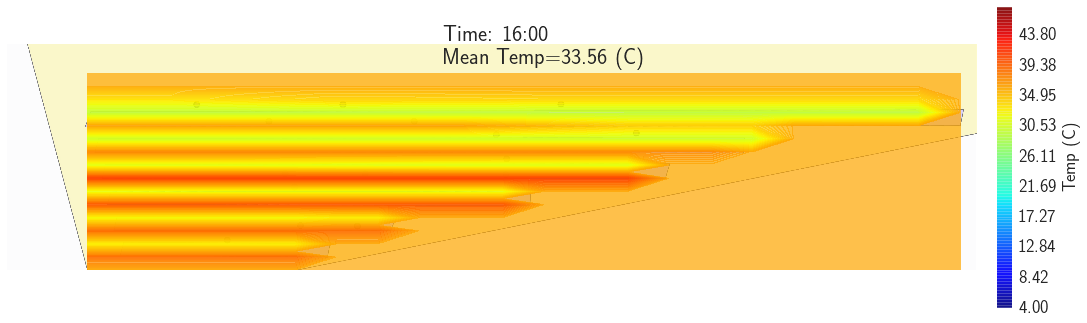

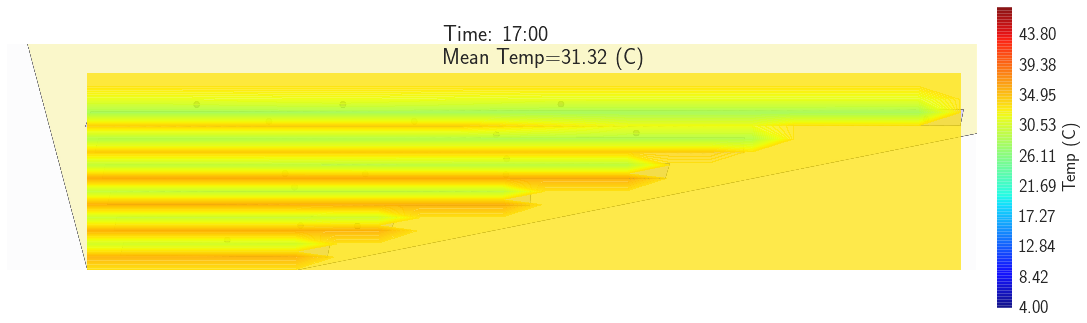

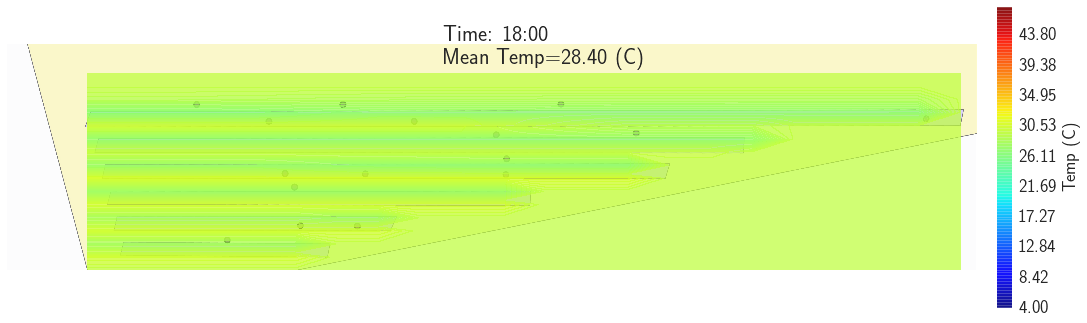

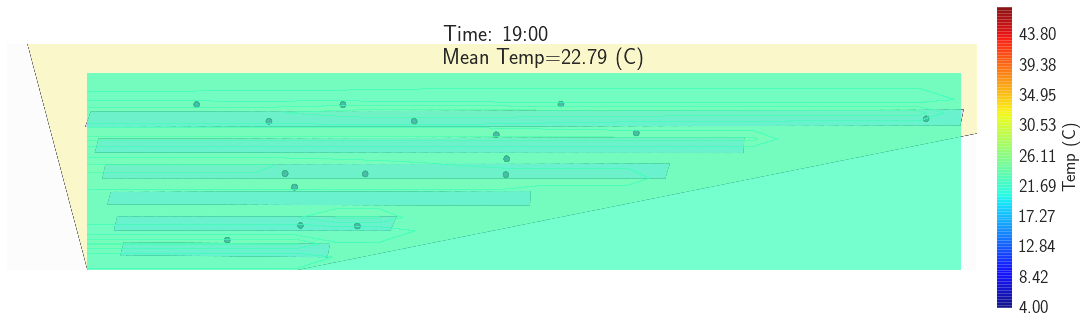

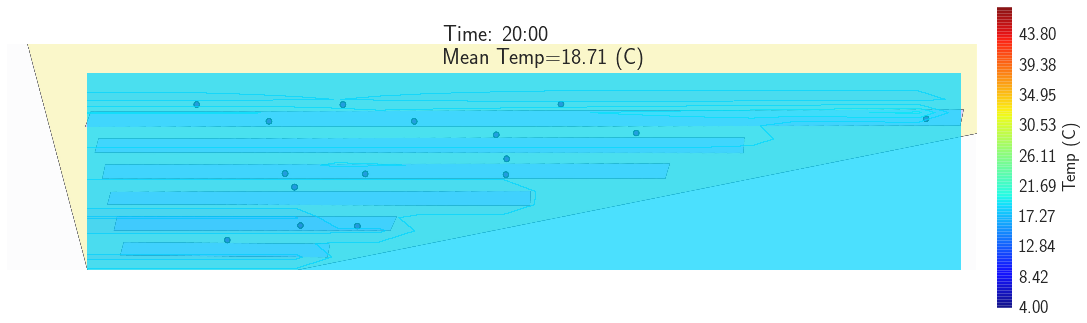

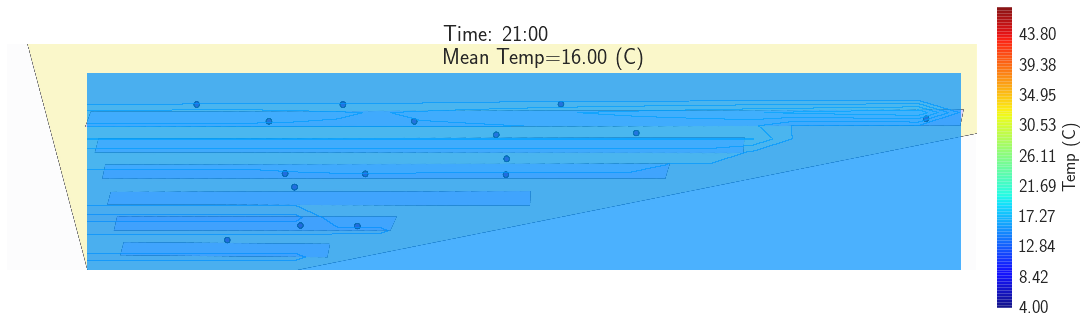

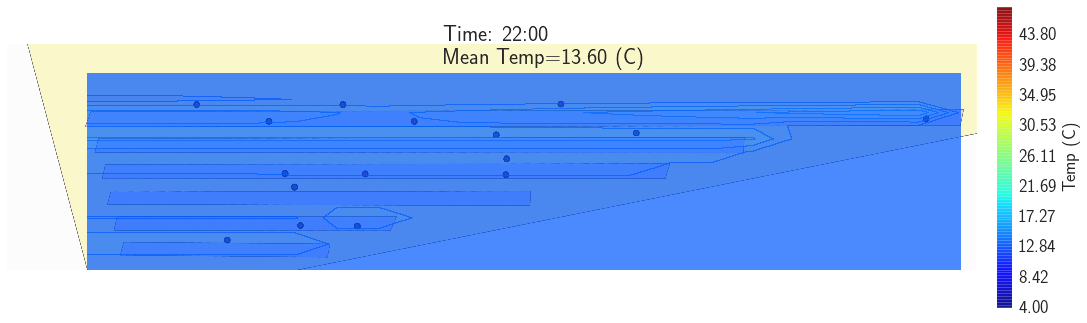

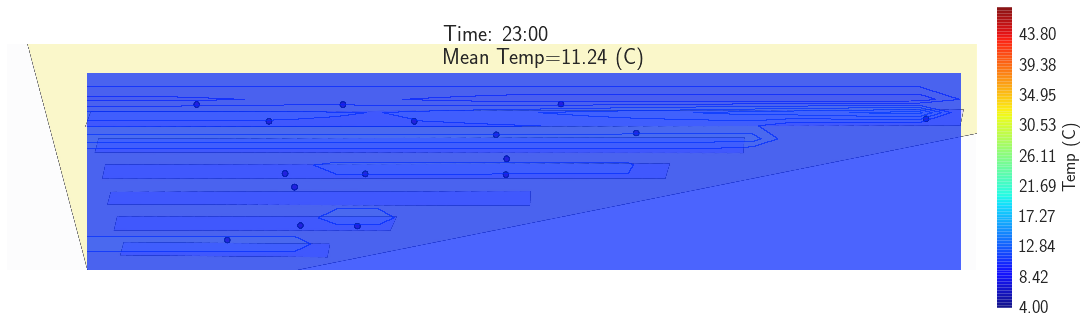

In [343]:
#Create a new folder to save the images 
dir_path='AniT'
if not (os.path.isdir(dir_path)):
    os.mkdir(dir_path)

#load ani data
vals_hours=loadtxt('data/Ani_temp.txt')

image_data = imread('Subsole.jpg').astype(np.float32)
image_data = imrotate(image_data,0.7)
print 'Size: ', image_data.size
print 'Shape: ', image_data.shape

scaled_image_data = image_data / 255.

#Make mesh grid
x = np.linspace(1000,6400,22)
y = np.linspace(2780,4000,16) #length of 76 per row (shade or sun)
X, Y = meshgrid(x, y)


for hour in np.arange(0,24):
    figure()    
    #import the data
    vals_contr=vals_hours[hour][:2] #first two are control. Will be used 
    vals=vals_hours[hour][2:] #the rest are measurements

    im=plt.imshow(scaled_image_data,alpha=0.9) #aspect='auto'
    plt.ylim([4000,2600])
    plt.xlim([500,6500])
    #plt.xlabel('xlabel', fontsize=18)
    #plt.ylabel('ylabel', fontsize=18)
    plt.xticks([],fontsize=18)
    plt.yticks([],fontsize=18)

    #setup the coordinates
    row_c= [1,20],[0,11],[1,7],[0,6],[1,4],[0,2],[2,13],[2,9],\
    [5,10],[4,10],\
    [5,6],[5,4],\
    [6,4],[9,6],[9,5],[10,3]

    #append the row,column data with values
    for ii in range(len(vals)):
        row_c[ii].append(vals[ii])
    
    #sort by row number
    a=np.array(row_c)
    sorted_a=a[np.lexsort(np.fliplr(a).T)] #sort the list of coordinates by row number
    sorted_a[:,0]=sorted_a[:,0]+2 #here we add two to the values of the rows defined above, since the first two are control.

    ave=mean(vals_contr) #get the ave of the control sensors
    Z=interp_row(sorted_a,n_rows=16,n_cols=22,ave=ave) #enter [row, column, val]

    ax=plt.gca()
    #levels=np.linspace(Z.min(),Z.max(),30) #this will adjust the color scale on each itteration
    levels=np.linspace(4,48,200)
    plt.contourf(X,Y,Z,levels,alpha=0.7,cmap='jet') #good ones: #cmap='jet' #'nipy_spectral'
    cb=plt.colorbar(fraction=0.015, pad=0.02,format="%.2f")
    cb.set_label('Temp (C)',fontsize=18)
    cb.ax.tick_params(labelsize=18)
    plt.text(3200,2730,'Time: '+ str(hour)+':00 \n Mean Temp='+'{:.2f}'.format(mean(vals))+' (C)',fontsize=22)
    
    # form a filename
    fname = 'AniT_'+str(hour)+'.png'
    # save the file
    savefig(dir_path+'/'+fname,dpi=200)
    # append the filename to the list
    files.append(fname)
 


<h1> Make a movie for the humidty data </h1>

Size:  90577536
Shape:  (4348, 6944, 3)


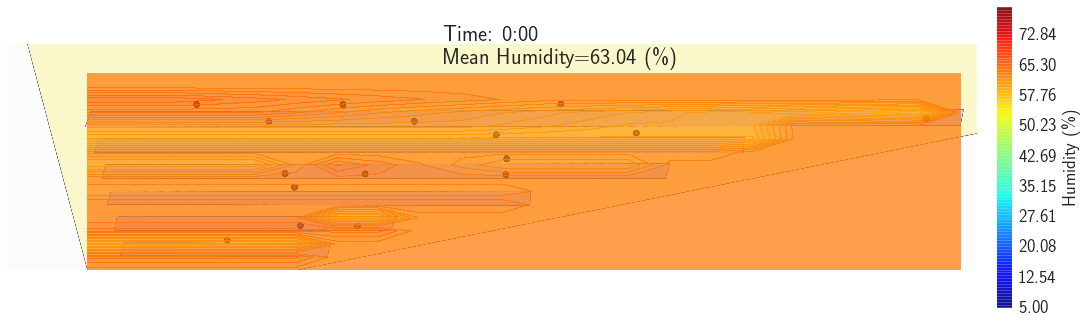

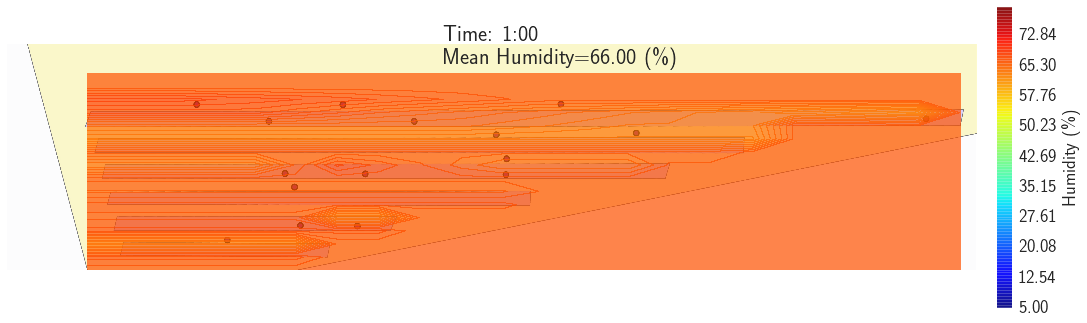

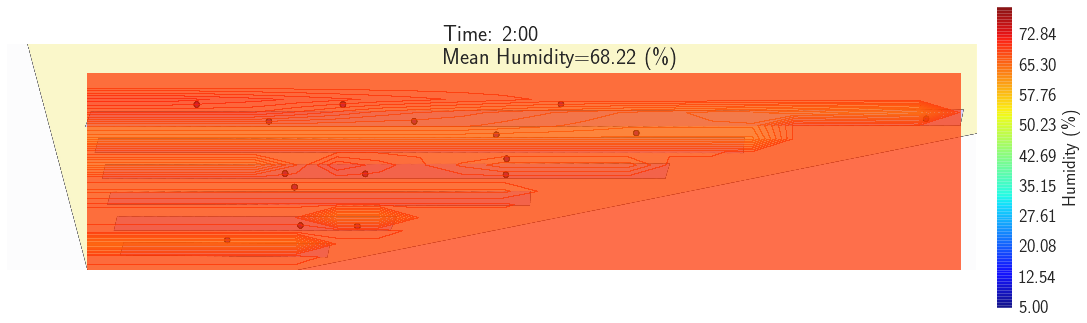

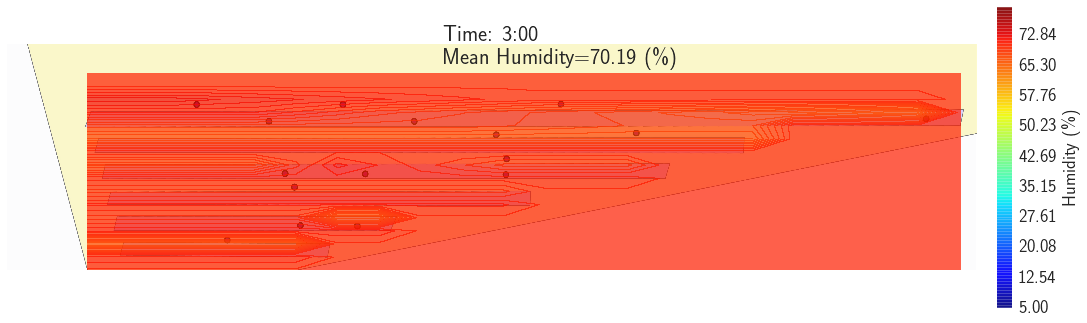

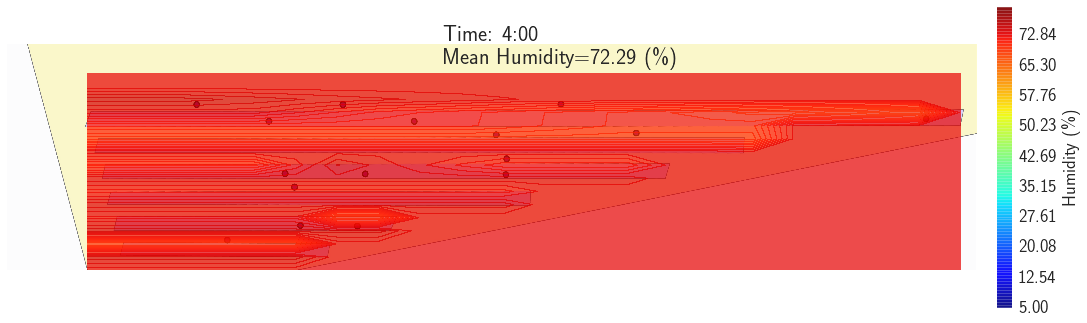

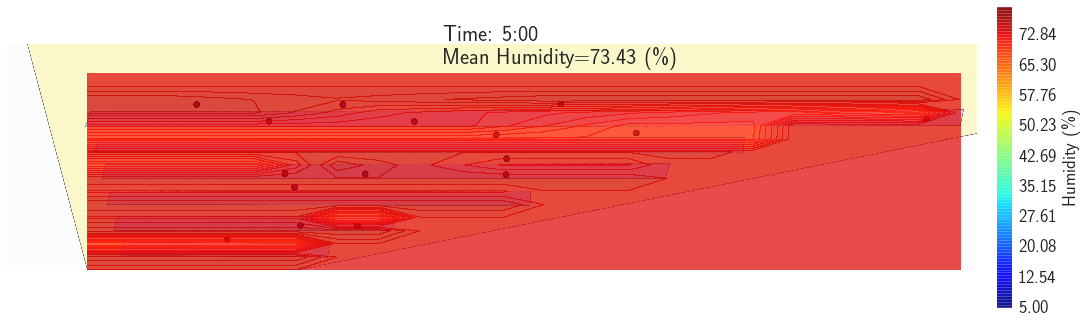

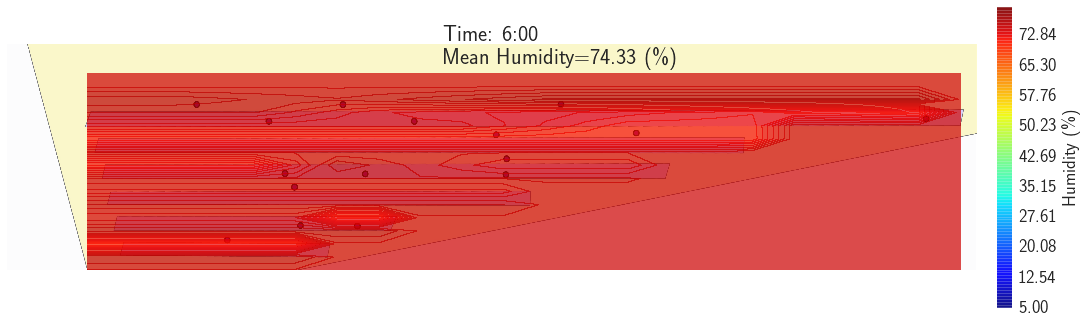

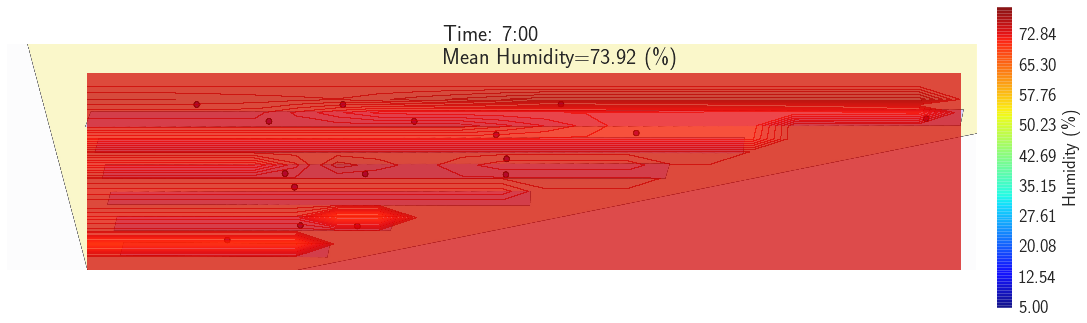

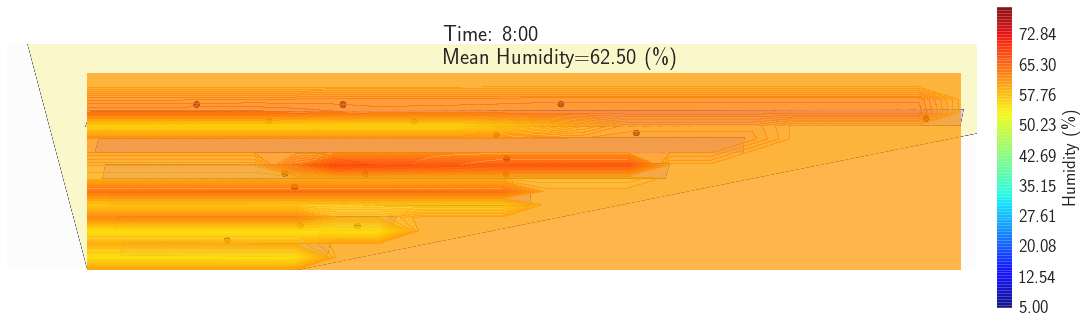

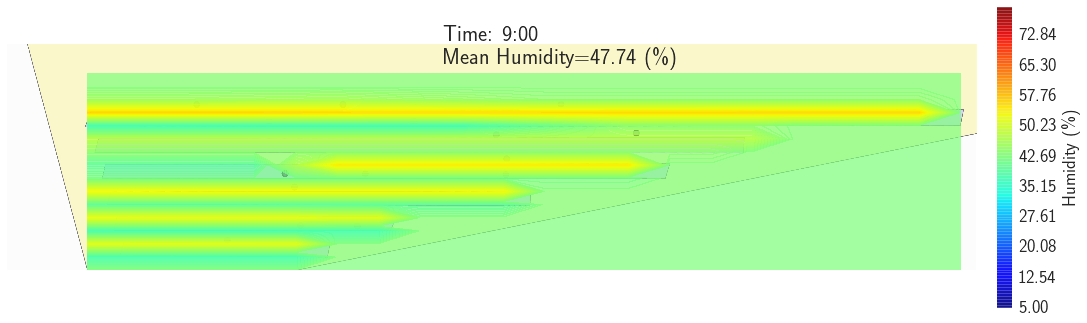

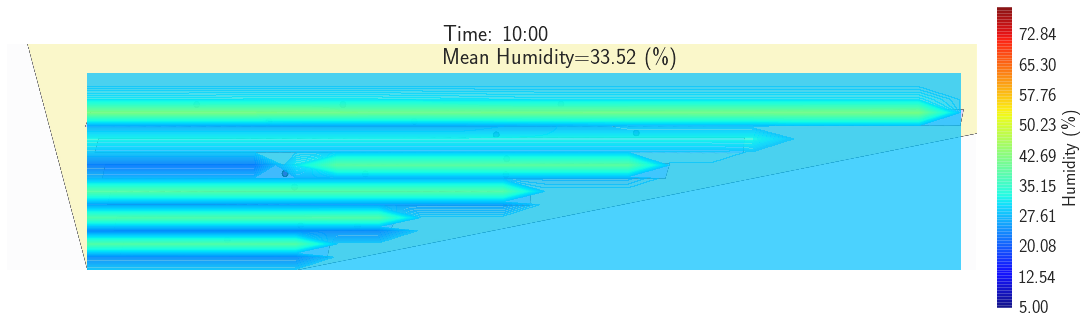

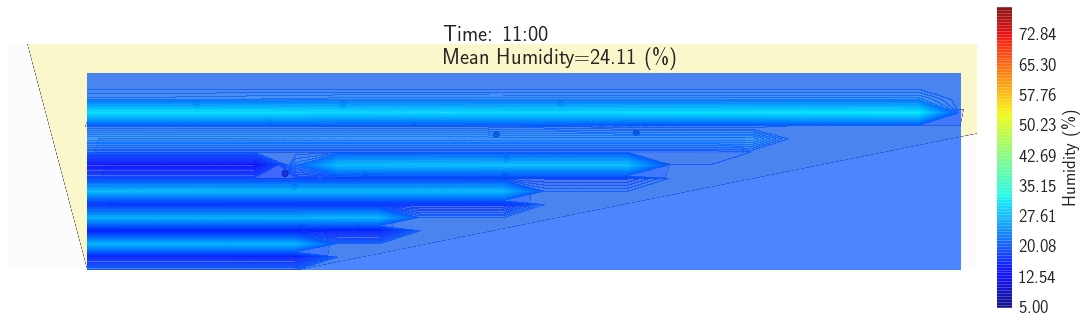

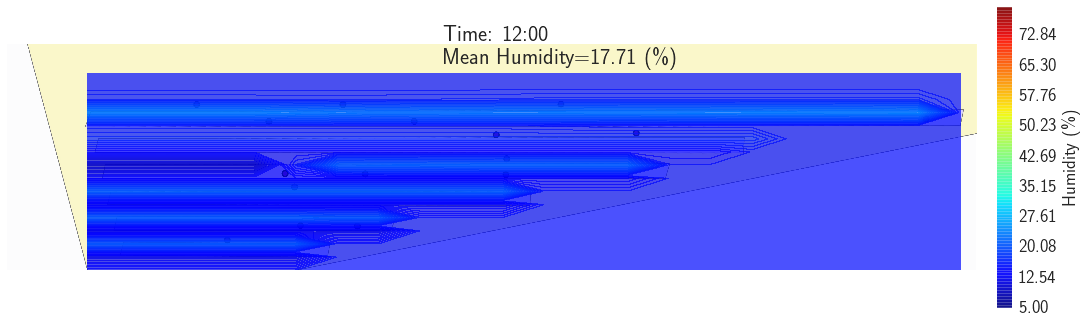

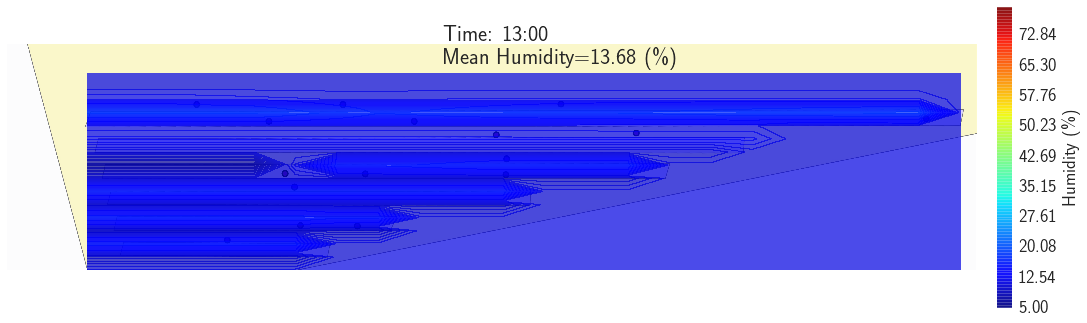

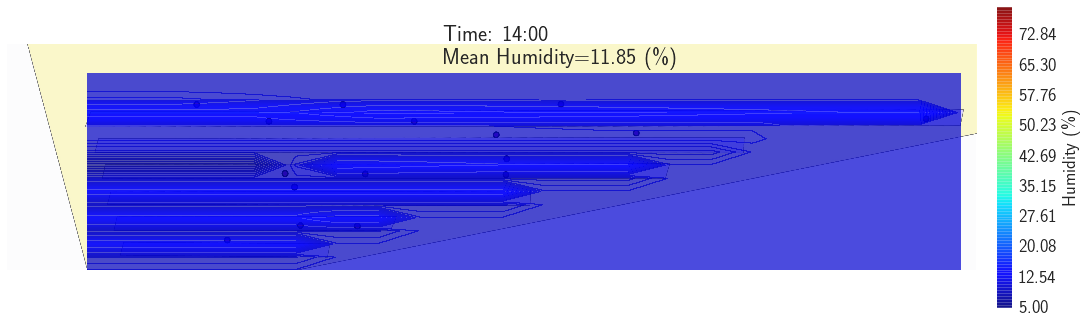

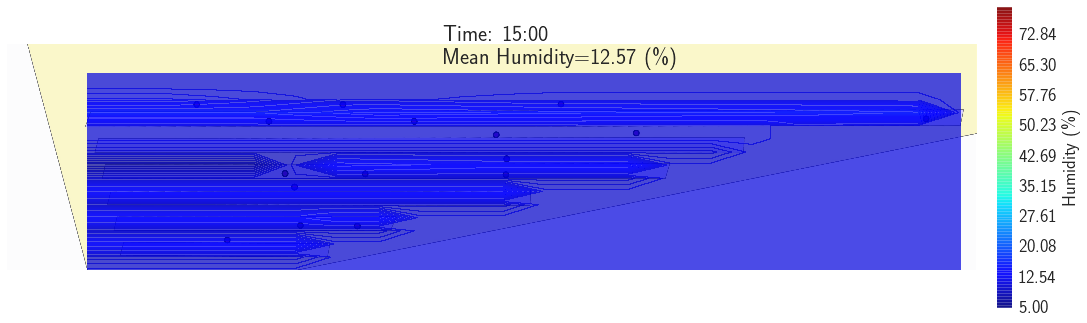

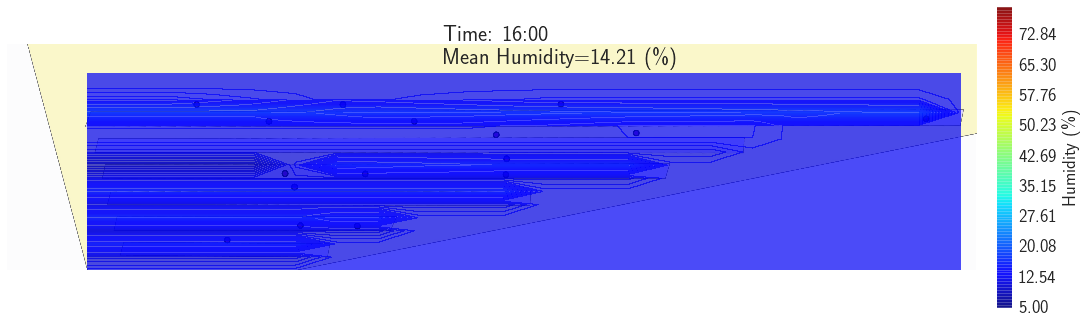

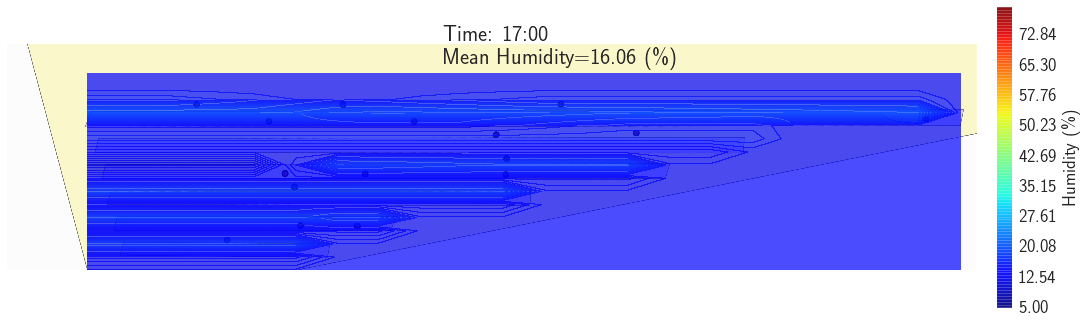

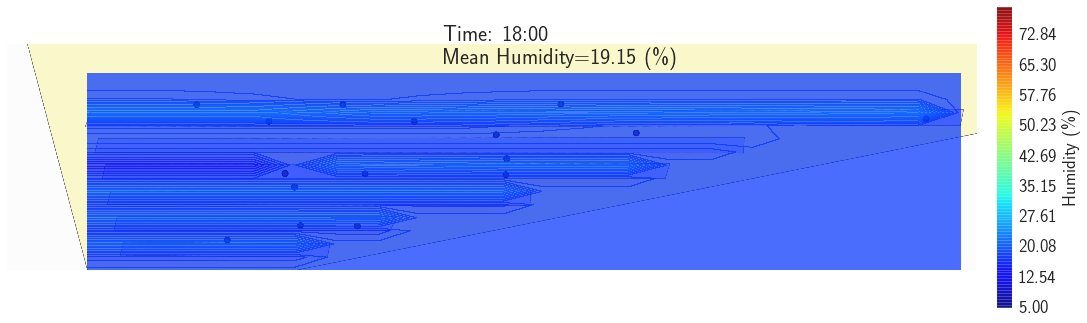

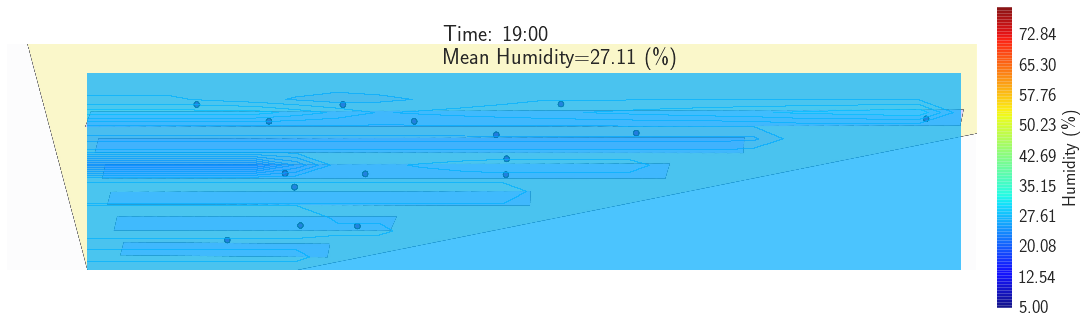

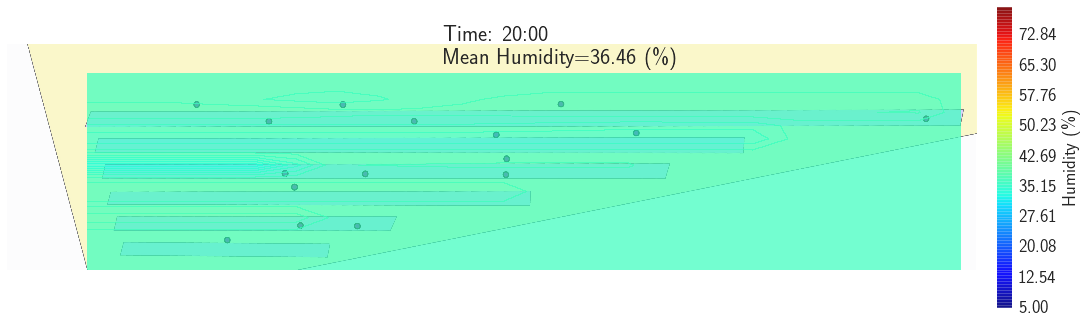

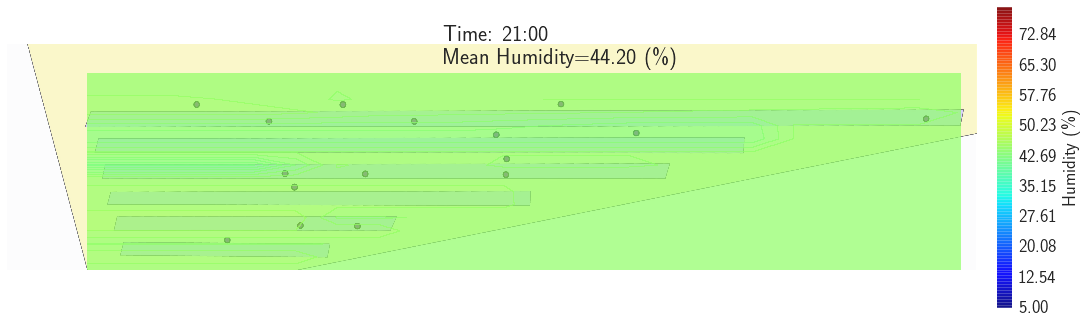

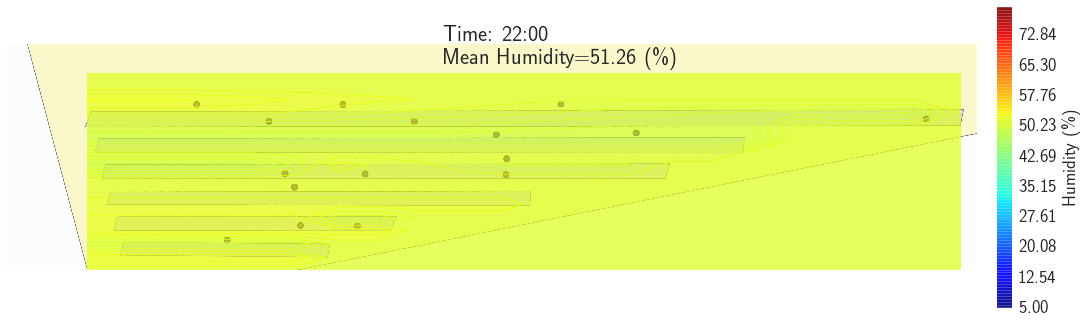

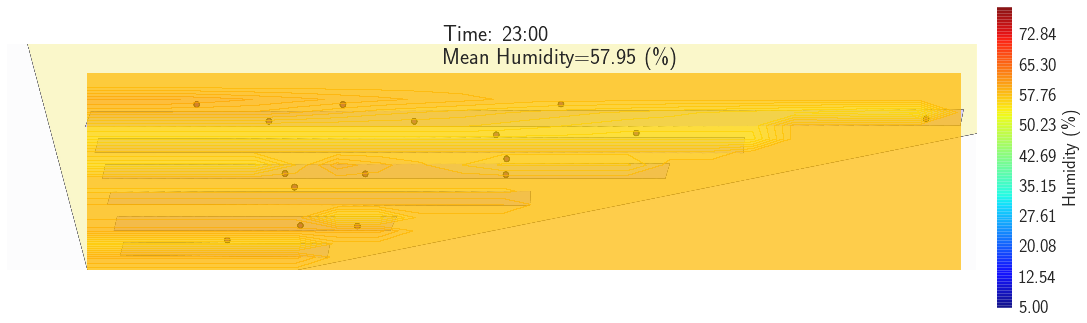

In [344]:
#Create a new folder to save the images 
dir_path='AniH'
if not (os.path.isdir(dir_path)):
    os.mkdir(dir_path)

#load ani data
vals_hours=loadtxt('data/Ani_hum.txt')

image_data = imread('Subsole.jpg').astype(np.float32)
image_data = imrotate(image_data,0.7)
print 'Size: ', image_data.size
print 'Shape: ', image_data.shape

scaled_image_data = image_data / 255.

#Make mesh grid
x = np.linspace(1000,6400,22)
y = np.linspace(2780,4000,16) #length of 76 per row (shade or sun)
X, Y = meshgrid(x, y)


for hour in np.arange(0,24):
    figure()    
    #import the data
    vals_contr=vals_hours[hour][:2] #first two are control. Will be used 
    vals=vals_hours[hour][2:] #the rest are measurements

    im=plt.imshow(scaled_image_data,alpha=0.9) #aspect='auto'
    plt.ylim([4000,2600])
    plt.xlim([500,6500])
    #plt.xlabel('xlabel', fontsize=18)
    #plt.ylabel('ylabel', fontsize=18)
    plt.xticks([],fontsize=18)
    plt.yticks([],fontsize=18)

    #setup the coordinates
    row_c= [1,20],[0,11],[1,7],[0,6],[1,4],[0,2],[2,13],[2,9],\
    [5,10],[4,10],\
    [5,6],[5,4],\
    [9,6],[9,5],[10,3] #removed [6,4]. HSh17 is missing from data

    #append the row,column data with values
    for ii in range(len(vals)):
        row_c[ii].append(vals[ii])
    
    #sort by row number
    a=np.array(row_c)
    sorted_a=a[np.lexsort(np.fliplr(a).T)] #sort the list of coordinates by row number
    sorted_a[:,0]=sorted_a[:,0]+2 #here we add two to the values of the rows defined above, since the first two are control.

    ave=mean(vals_contr) #get the ave of the control sensors
    Z=interp_row(sorted_a,n_rows=16,n_cols=22,ave=ave) #enter [row, column, val]

    ax=plt.gca()
    #levels=np.linspace(Z.min(),Z.max(),30) #this will adjust the color scale on each itteration
    levels=np.linspace(5,80,200)
    plt.contourf(X,Y,Z,levels,alpha=0.7,cmap='jet') #good ones: #cmap='jet' #'nipy_spectral'
    cb=plt.colorbar(fraction=0.015, pad=0.02,format="%.2f")
    cb.set_label('Humidity (\%)',fontsize=18)
    cb.ax.tick_params(labelsize=18)
    plt.text(3200,2730,'Time: '+ str(hour)+':00 \n Mean Humidity='+'{:.2f}'.format(mean(vals))+' (\%)',fontsize=22)
    
    # form a filename
    fname = 'AniH_'+str(hour)+'.png'
    # save the file
    savefig(dir_path+'/'+fname,dpi=200)
    # append the filename to the list
    files.append(fname)
 



<h1> Make move for Dewpoint data </h1>

Size:  90577536
Shape:  (4348, 6944, 3)


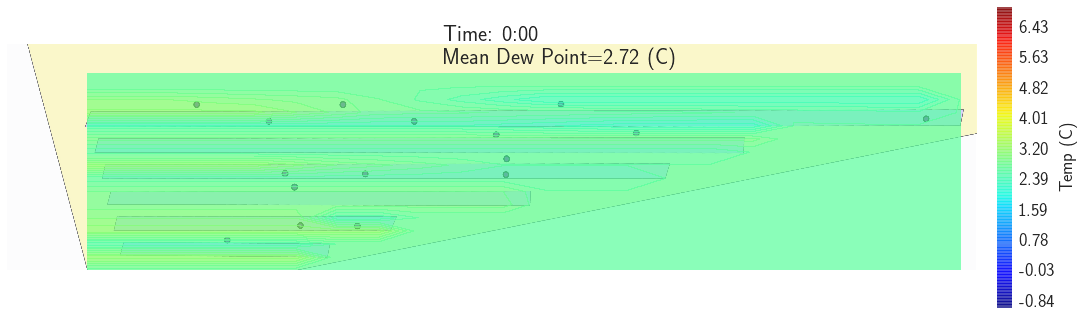

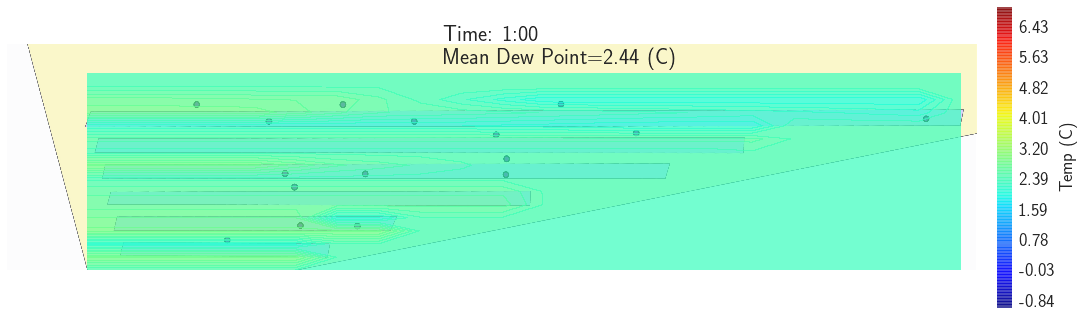

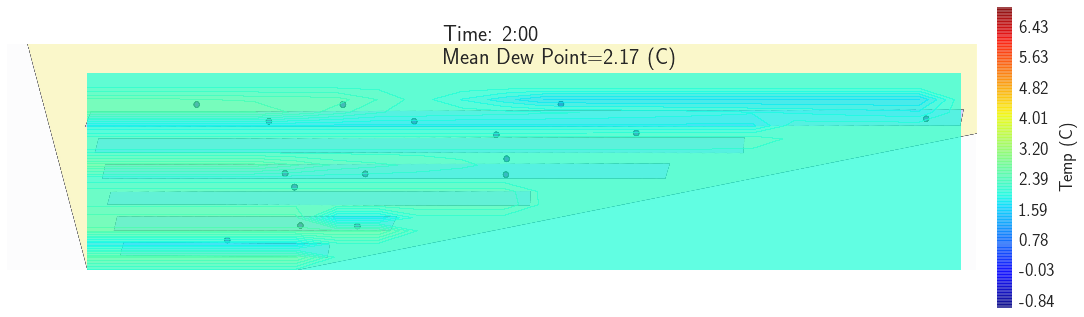

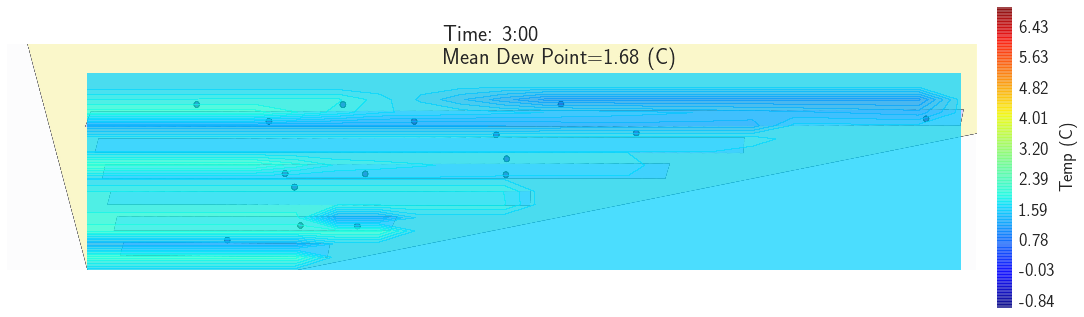

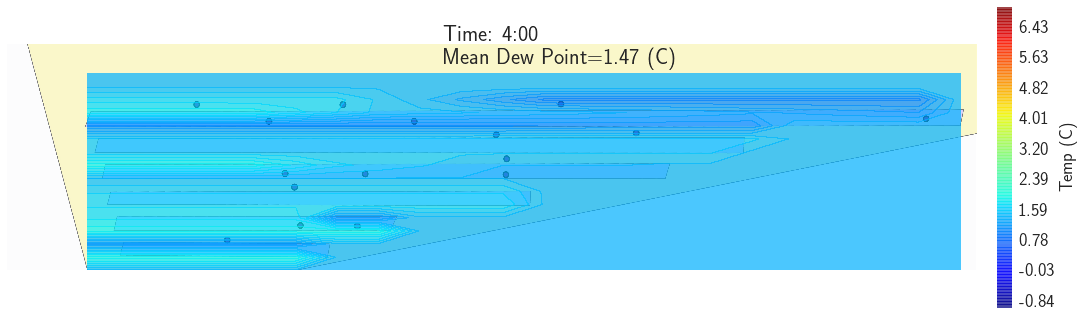

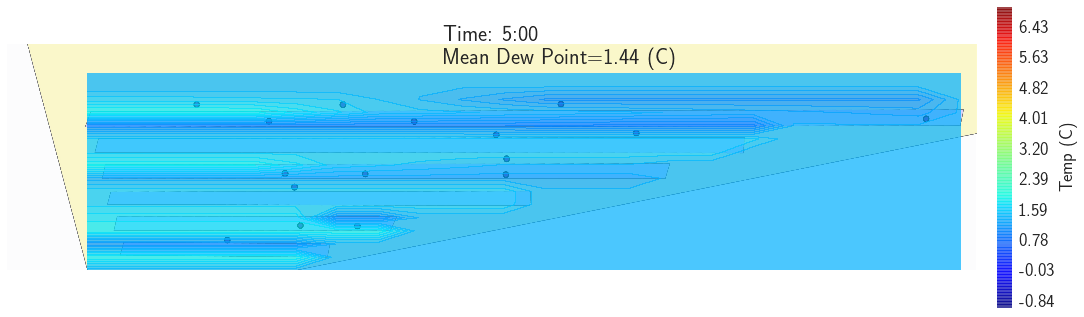

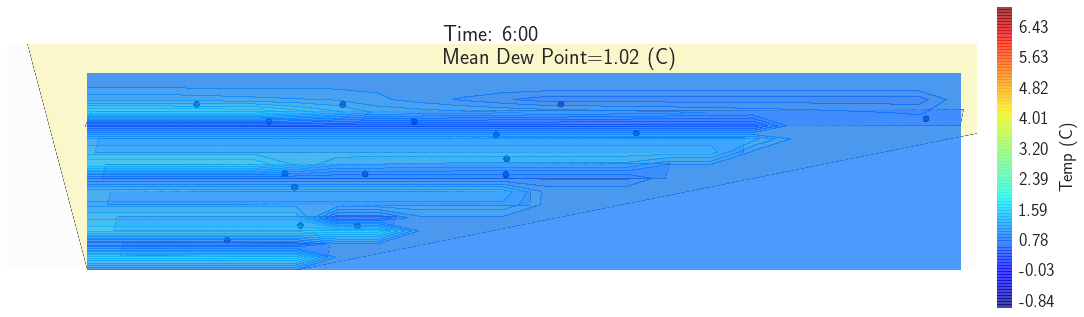

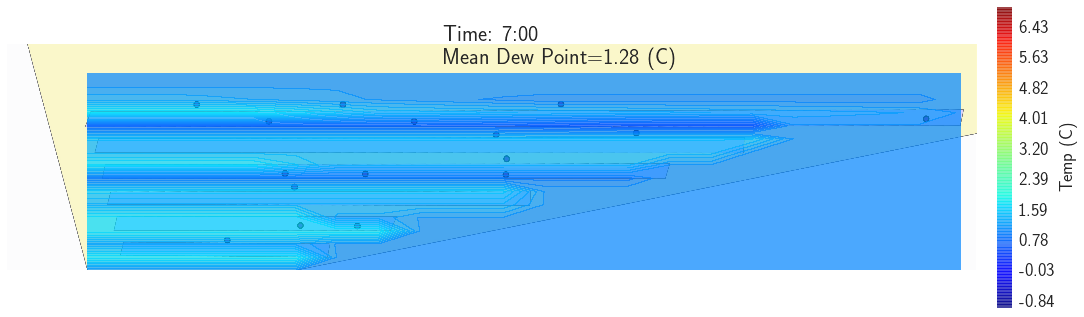

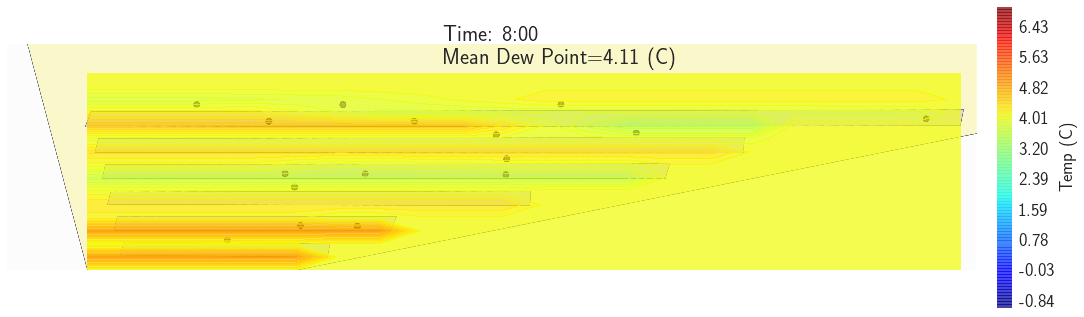

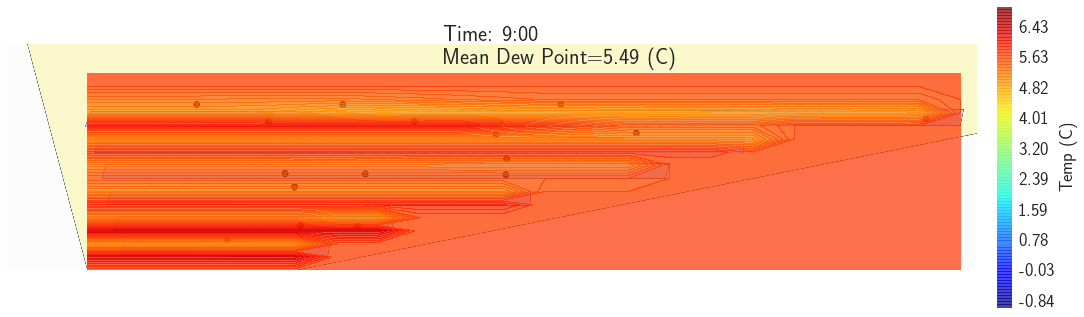

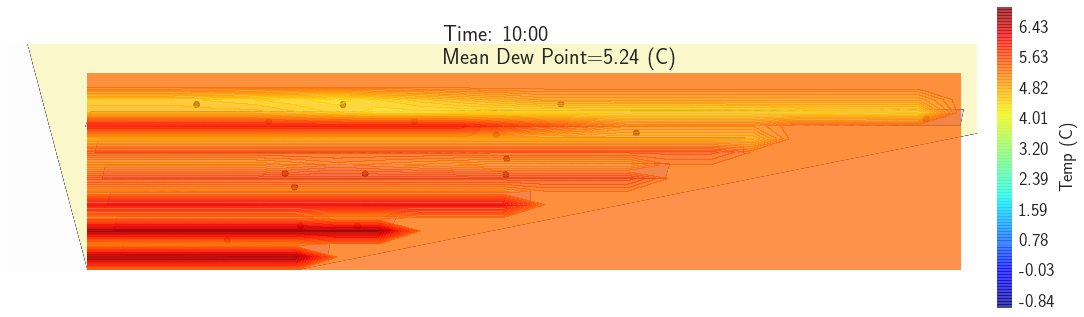

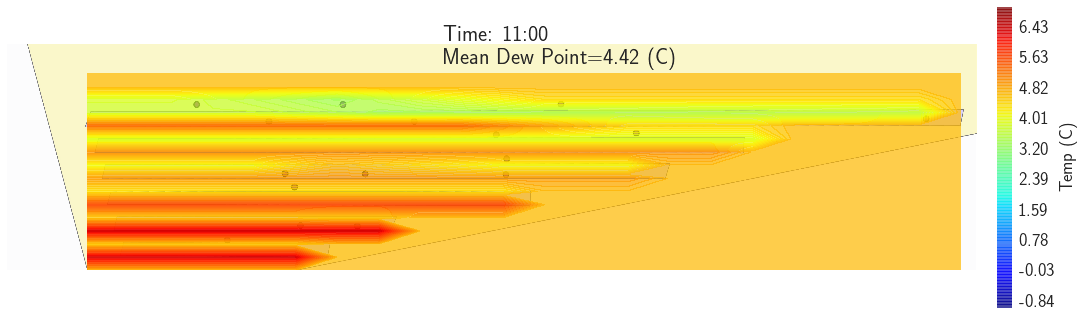

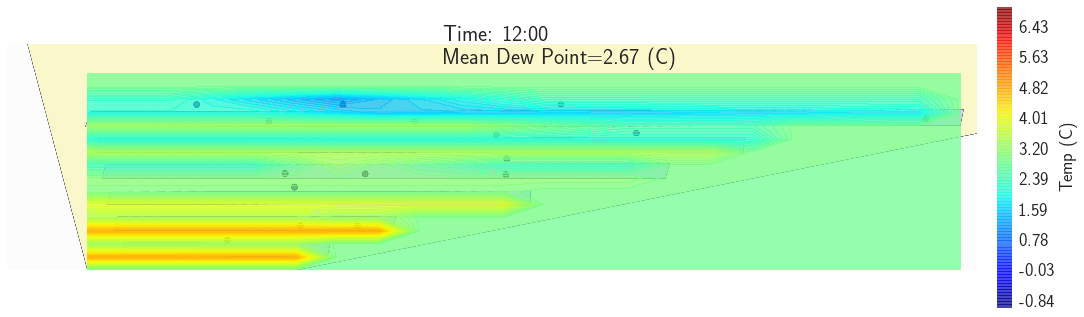

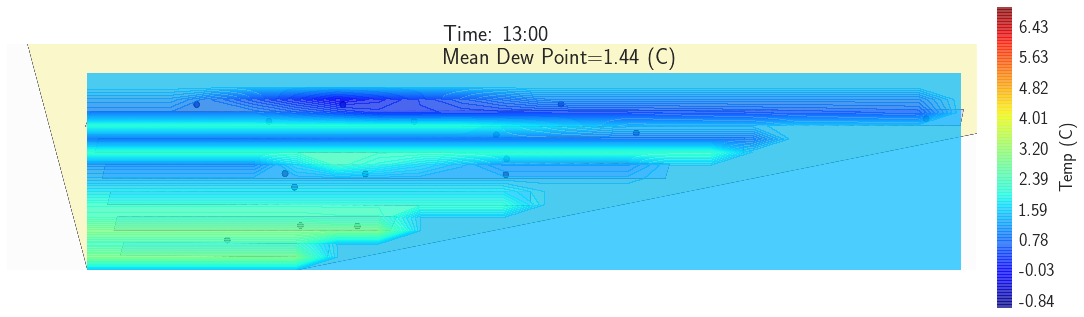

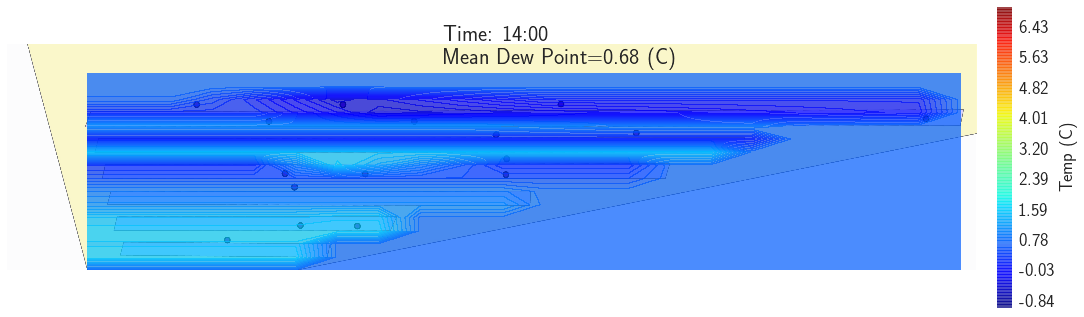

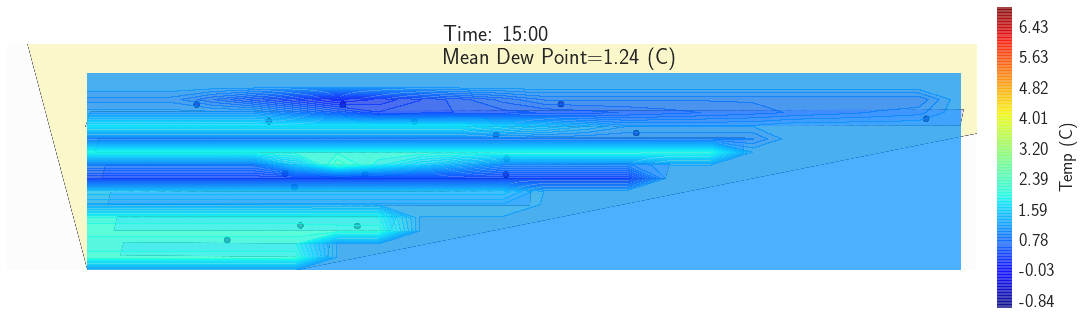

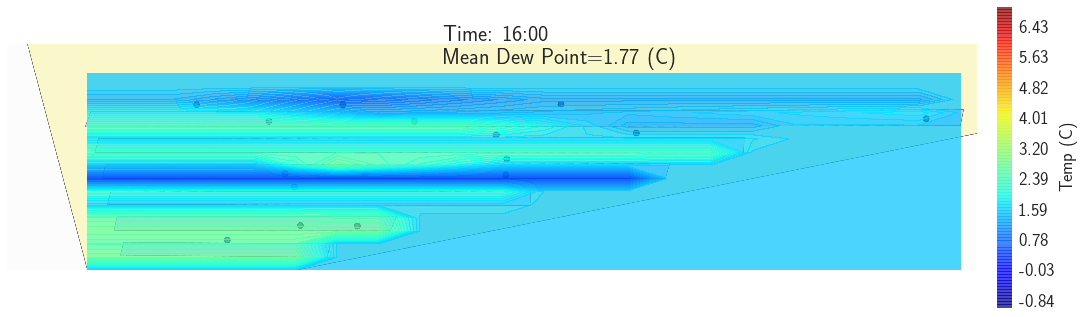

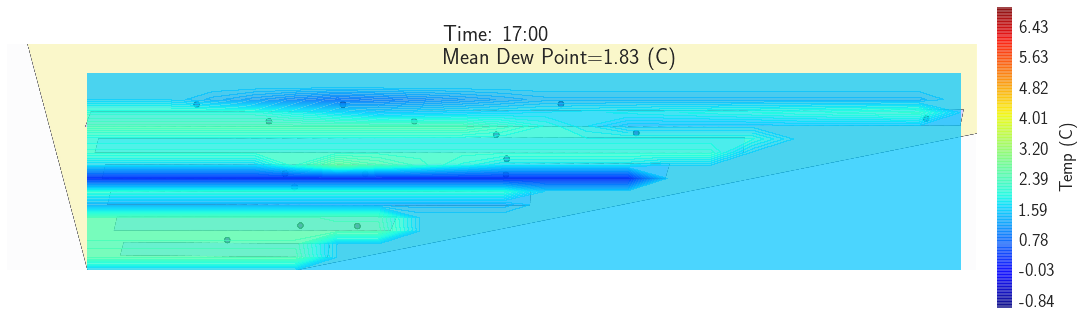

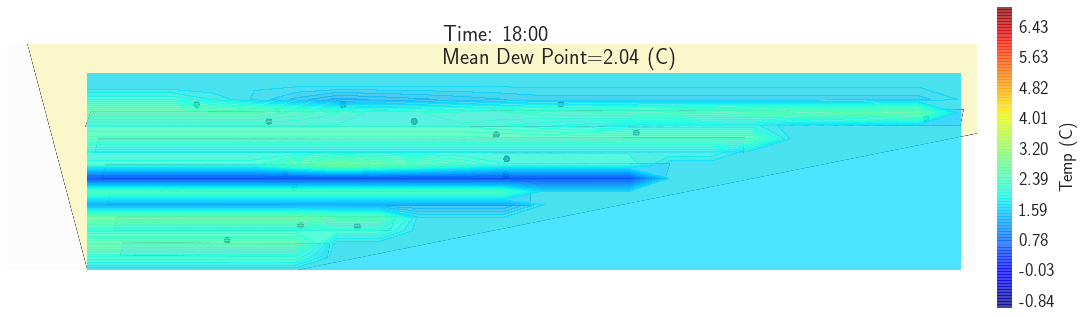

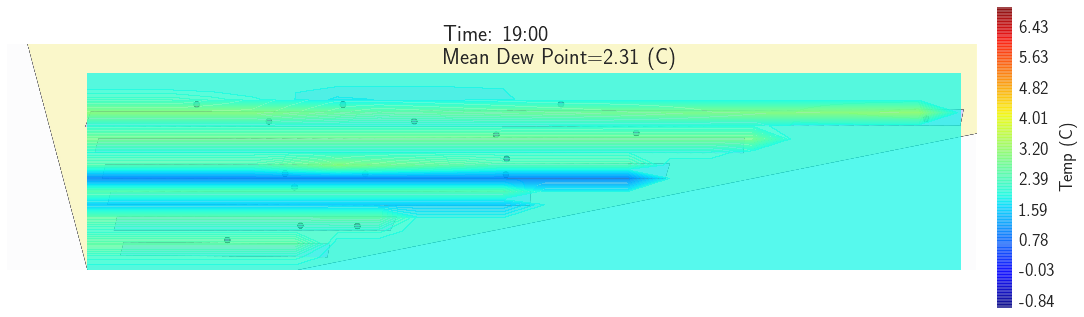

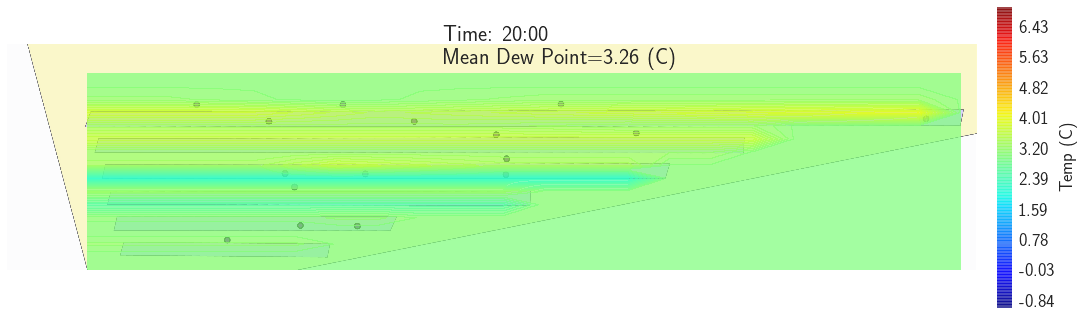

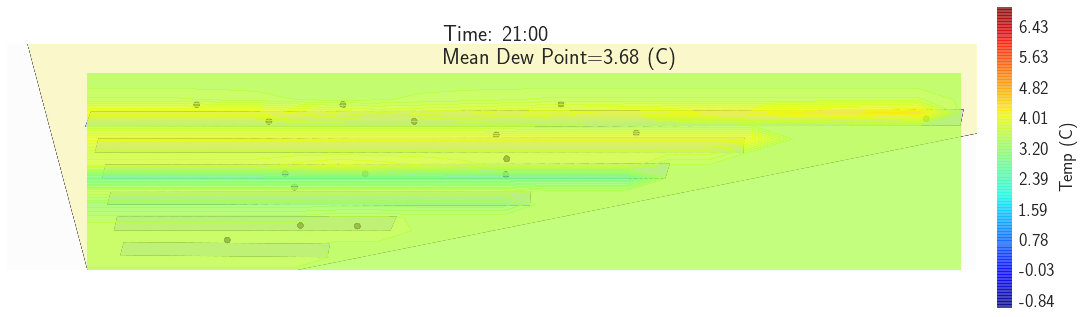

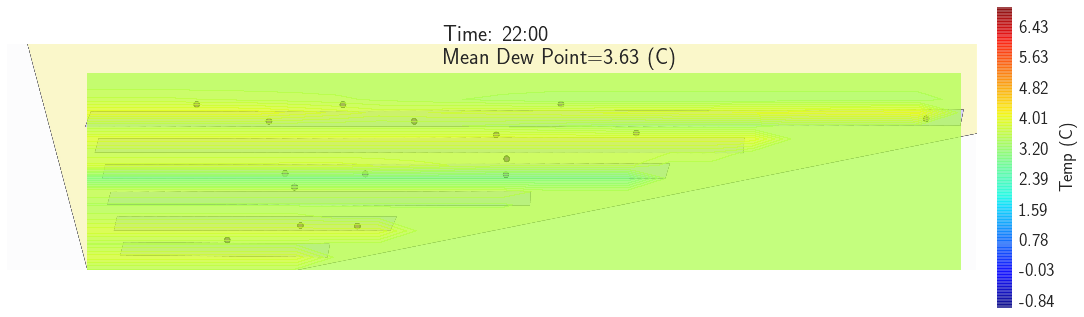

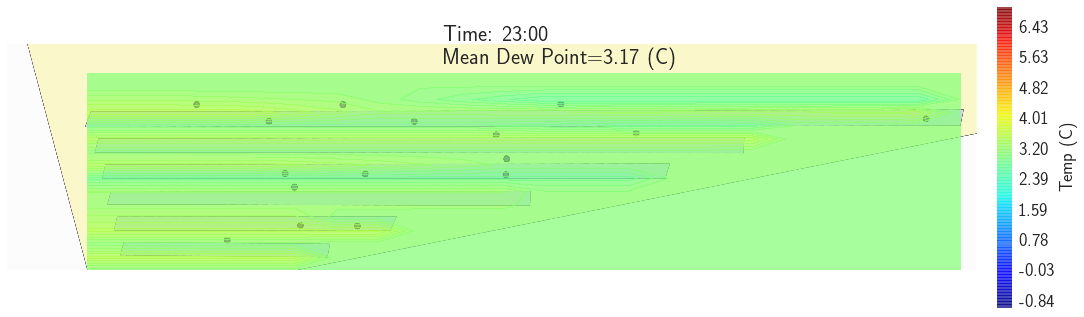

In [345]:
#Create a new folder to save the images 
dir_path='AniD'
if not (os.path.isdir(dir_path)):
    os.mkdir(dir_path)

#load ani data
vals_hours=loadtxt('data/Ani_dew.txt')

image_data = imread('Subsole.jpg').astype(np.float32)
image_data = imrotate(image_data,0.7)
print 'Size: ', image_data.size
print 'Shape: ', image_data.shape

scaled_image_data = image_data / 255.

#Make mesh grid
x = np.linspace(1000,6400,22)
y = np.linspace(2780,4000,16) #length of 76 per row (shade or sun)
X, Y = meshgrid(x, y)


for hour in np.arange(0,24):
    figure()    
    #import the data
    vals_contr=vals_hours[hour][:2] #first two are control. Will be used 
    vals=vals_hours[hour][2:] #the rest are measurements

    im=plt.imshow(scaled_image_data,alpha=0.9) #aspect='auto'
    plt.ylim([4000,2600])
    plt.xlim([500,6500])
    #plt.xlabel('xlabel', fontsize=18)
    #plt.ylabel('ylabel', fontsize=18)
    plt.xticks([],fontsize=18)
    plt.yticks([],fontsize=18)

    #setup the coordinates
    row_c= [1,20],[0,11],[1,7],[0,6],[1,4],[0,2],[2,13],[2,9],\
    [5,10],[4,10],\
    [5,6],[5,4],\
    [6,4],[9,6],[9,5],[10,3]

    #append the row,column data with values
    for ii in range(len(vals)):
        row_c[ii].append(vals[ii])
    
    #sort by row number
    a=np.array(row_c)
    sorted_a=a[np.lexsort(np.fliplr(a).T)] #sort the list of coordinates by row number
    sorted_a[:,0]=sorted_a[:,0]+2 #here we add two to the values of the rows defined above, since the first two are control.

    ave=mean(vals_contr) #get the ave of the control sensors
    Z=interp_row(sorted_a,n_rows=16,n_cols=22,ave=ave) #enter [row, column, val]

    ax=plt.gca()
    #levels=np.linspace(Z.min(),Z.max(),30) #this will adjust the color scale on each itteration
    levels=np.linspace(-1,7,100)
    plt.contourf(X,Y,Z,levels,alpha=0.7,cmap='jet') #good ones: #cmap='jet' #'nipy_spectral'
    cb=plt.colorbar(fraction=0.015, pad=0.02,format="%.2f")
    cb.set_label('Temp (C)',fontsize=18)
    cb.ax.tick_params(labelsize=18)
    plt.text(3200,2730,'Time: '+ str(hour)+':00 \n Mean Relative Dew Point='+'{:.2f}'.format(mean(vals))+' (C)',fontsize=22)
    
    # form a filename
    fname = 'AniD_'+str(hour)+'.png'
    # save the file
    savefig(dir_path+'/'+fname,dpi=200)
    # append the filename to the list
    files.append(fname)
 